In [1]:
import json
from pathlib import Path
import sys
sys.path.insert(1, '../src')
sys.path.insert(1, '../src/utils')
import itertools
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE, SpectralEmbedding
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

from preprocessing import Preprocessing
from config import Config

import pickle

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Variables

In [4]:
num_topics = 5
use_title = True
# don't use stemming
stemming = False
lemmatization = True
# use nltk since it is a lot faster than spacy and the results are better with nltk
lib = "nltk"

input_path = Path("../src/data/data_jmlr_vol13-21.json")

# Data loading and preparation

## Load data

In [5]:
def load_data():
    with open(input_path, encoding="utf-8") as f:
        data = json.load(f)
    data_df = pd.json_normalize(data['papers'])
    corpus = data_df["abstract"]
    if use_title:
        corpus = data_df["title"] + " " + corpus 
    return corpus

corpus = load_data()

## Preprocessing

In [6]:
config = Config.from_file("config_notebook.yaml")
corpus = Preprocessing(
        corpus,
        config=config.preprocessing,
    ).apply_preprocessing()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
1261it [00:08, 145.42it/s]


### TD-IDF

In [7]:
vectorizer = TfidfVectorizer(tokenizer=lambda text: text, lowercase=False)  
tfidf_corpus =  vectorizer.fit_transform(corpus["token"])

# Clustering

In [8]:
bandwidth = estimate_bandwidth(tfidf_corpus.toarray(), quantile=0.2, n_samples=500)

tdidf_meanshift_clustering = MeanShift(bandwidth=bandwidth, n_jobs=6)
tdidf_meanshift_clustering.fit(tfidf_corpus.toarray())

MeanShift(bandwidth=1.376966346191656, n_jobs=6)

In [9]:
pickle.dump(tdidf_meanshift_clustering, open('meanshift_data/tdidf_meanshift_clustering', 'wb'))

FileNotFoundError: [Errno 2] No such file or directory: 'meanshift_data/tdidf_meanshift_clustering'

In [10]:
def get_top_words(vectorizer, corpus):
    scores = zip(vectorizer.get_feature_names(),
                 np.asarray(corpus.sum(axis=0)).ravel())
    sorted_scores = list(zip(*sorted(scores, key=lambda x: x[1], reverse=True)))
    top_words = sorted_scores[0][:10]
    return top_words
    

def print_and_get_clusters(model, corpus):
    labels = model.labels_
    labels_unique = np.unique(labels)
    n_clusters_ = len(labels_unique)
    
    clusters = []
    print("Top terms per cluster:")
    for i in range(n_clusters_):
        print("Cluster %d:" % i)
        vectorizer_terms = TfidfVectorizer(tokenizer=lambda text: text, lowercase=False)  
        tfidf_corpus_terms = vectorizer_terms.fit_transform(corpus.iloc[np.where(model.labels_ == i)]["token"])
        top_words = get_top_words(vectorizer_terms, tfidf_corpus_terms)
        print(top_words)
        clusters.append(top_words)
        print("\n")
    
    return clusters

In [11]:
clusters = print_and_get_clusters(tdidf_meanshift_clustering, corpus)

Top terms per cluster:
Cluster 0:
('model', 'learning', 'algorithm', 'data', 'method', 'problem', 'function', 'matrix', 'kernel', 'regression')




# Visualization

In [12]:
def visualize_clustering_result_arr(model, X):
    labels = model.labels_
    cluster_centers = model.cluster_centers_

    labels_unique = np.unique(labels)
    n_clusters_ = len(labels_unique)

    print("number of estimated clusters : %d" % n_clusters_)

    plt.figure(1)
    plt.clf()

    colors = itertools.cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
    for k, col in zip(range(n_clusters_), colors):
        my_members = labels == k
        cluster_center = cluster_centers[k]
        plt.plot(X[my_members, 0], X[my_members, 1], col + '.')
        plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
                 markeredgecolor='k', markersize=14)
    plt.title('Estimated number of clusters: %d' % n_clusters_)
    plt.show()
    
def visualize_clustering_result(model, corpus):
    visualize_clustering_result_arr(model, corpus.toarray())

number of estimated clusters : 1


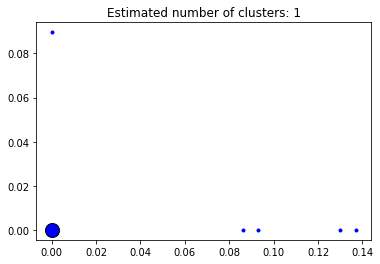

In [13]:
visualize_clustering_result(tdidf_meanshift_clustering, tfidf_corpus)

# Try different arguments for `MeanShift`

bin_seeding: True, min_bin: 1, cluster_all: True, max_iter: 150
number of estimated clusters : 1


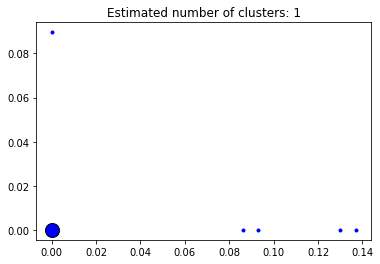

Top terms per cluster:
Cluster 0:
('model', 'learning', 'algorithm', 'data', 'method', 'problem', 'function', 'matrix', 'kernel', 'regression')




FileNotFoundError: [Errno 2] No such file or directory: 'meanshift_data/meanshift_True_1_True_150'

In [14]:
bin_seeding_values = [True, False]
min_bin_freqs = [1, 3, 5]
cluster_all_values = [True, False]
max_iters = [150, 300]

for bin_seeding in bin_seeding_values:
    for min_bin in min_bin_freqs:
        for cluster_all in cluster_all_values:
            for max_iter in max_iters:
                print(f'bin_seeding: {bin_seeding}, min_bin: {min_bin}, cluster_all: {cluster_all}, max_iter: {max_iter}')

                tdidf_meanshift_clustering_alt = MeanShift(bandwidth=bandwidth, bin_seeding=bin_seeding, min_bin_freq=min_bin, cluster_all=cluster_all, max_iter=max_iter, n_jobs=6)
                tdidf_meanshift_clustering_alt.fit(tfidf_corpus.toarray())

                visualize_clustering_result(tdidf_meanshift_clustering_alt, tfidf_corpus)
                clusters_alt = print_and_get_clusters(tdidf_meanshift_clustering_alt, corpus)

                pickle.dump(tdidf_meanshift_clustering_alt, open(f'meanshift_data/meanshift_{bin_seeding}_{min_bin}_{cluster_all}_{max_iter}', 'wb'))

#  Remove words which appear often in all clusters

In [15]:
terms = list(itertools.chain.from_iterable(clusters))
Counter(terms).most_common

<bound method Counter.most_common of Counter({'model': 1, 'learning': 1, 'algorithm': 1, 'data': 1, 'method': 1, 'problem': 1, 'function': 1, 'matrix': 1, 'kernel': 1, 'regression': 1})>

In [16]:
custom_stopwords = ["model", "learning", "algorithm", "data", "method"]

In [17]:
corpus_new = load_data()

config = Config.from_file("config_notebook_stopwords.yaml")
corpus_stopwords = Preprocessing(
        corpus_new,
        config=config.preprocessing,
    ).apply_preprocessing()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
1261it [00:05, 247.30it/s]


In [18]:
vectorizer_stopwords = TfidfVectorizer(tokenizer=lambda text: text, lowercase=False)  
tfidf_corpus_stopwords = vectorizer_stopwords.fit_transform(corpus_stopwords["token"])

In [19]:
tdidf_meanshift_clustering_stopwords = MeanShift(bandwidth=bandwidth, n_jobs=6)
tdidf_meanshift_clustering_stopwords.fit(tfidf_corpus.toarray())

MeanShift(bandwidth=1.376966346191656, n_jobs=6)

number of estimated clusters : 1


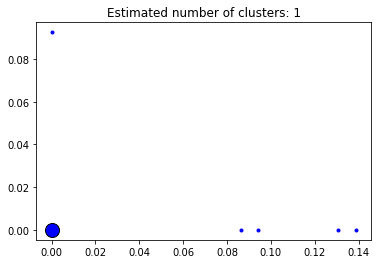

In [20]:
visualize_clustering_result(tdidf_meanshift_clustering_stopwords, tfidf_corpus_stopwords)

In [21]:
clusters = print_and_get_clusters(tdidf_meanshift_clustering_stopwords, corpus_stopwords)

Top terms per cluster:
Cluster 0:
('problem', 'function', 'matrix', 'kernel', 'regression', 'network', 'approach', 'based', 'set', 'graph')




# Metrics

In [22]:
def calc_scores(corpus, model):
    return metrics.silhouette_score(corpus, model.labels_, metric='euclidean'), metrics.calinski_harabasz_score(corpus.toarray(), model.labels_), metrics.davies_bouldin_score(corpus.toarray(), model.labels_)

# not possible, only 1 cluster
scores = []

score = list(calc_scores(tfidf_corpus, tdidf_meanshift_clustering))
score.insert(0, 'normal model')
scores.append(score)

score = list(calc_scores(tfidf_corpus_stopwords, tdidf_meanshift_clustering_stopwords))
score.insert(0, 'model with custom stopwords')
scores.append(score)

scores = pd.DataFrame(scores, columns=["model type","silhouette_score", "calinski_harabasz_score", "davies_bouldin_score"])
print(scores)

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

# Test with SpectralEmbedding

In [23]:
vectorizer_spec_embedding = TfidfVectorizer(tokenizer=lambda text: text, lowercase=False)  
tfidf_corpus_spec_embedding = vectorizer_spec_embedding.fit_transform(corpus["token"])
tfidf_corpus_spec_embedding_array = SpectralEmbedding(n_components=2).fit_transform(tfidf_corpus_spec_embedding.toarray())

In [24]:
bandwidth = estimate_bandwidth(tfidf_corpus_spec_embedding_array, quantile=0.2, n_samples=500)

tdidf_meanshift_clustering_spectral = MeanShift(bandwidth=bandwidth, n_jobs=6)
tdidf_meanshift_clustering_spectral.fit(tfidf_corpus_spec_embedding_array)

pickle.dump(tdidf_meanshift_clustering_spectral, open('meanshift_data/tdidf_meanshift_clustering_spectral', 'wb'))

MeanShift(bandwidth=0.002615771648671066, n_jobs=6)

In [25]:
clusters = print_and_get_clusters(tdidf_meanshift_clustering_spectral, corpus)

Top terms per cluster:
Cluster 0:
('model', 'algorithm', 'learning', 'data', 'method', 'problem', 'function', 'matrix', 'regression', 'kernel')


Cluster 1:
('learning', 'data', 'algorithm', 'machine', 'library', 'python', 'model', 'multi', 'task', 'package')




number of estimated clusters : 2


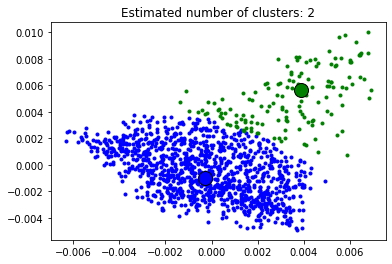

In [26]:
visualize_clustering_result_arr(tdidf_meanshift_clustering_spectral, tfidf_corpus_spec_embedding_array)

In [27]:
def calc_scores_arr(corpus, model):
    return metrics.silhouette_score(corpus, model.labels_, metric='euclidean'), metrics.calinski_harabasz_score(corpus, model.labels_), metrics.davies_bouldin_score(corpus, model.labels_)

scores = []

score = list(calc_scores_arr(tfidf_corpus_spec_embedding_array, tdidf_meanshift_clustering_spectral))
score.insert(0, 'model with spectral embedding')
scores.append(score)


scores = pd.DataFrame(scores, columns=["model type","silhouette_score", "calinski_harabasz_score", "davies_bouldin_score"])
print(scores)

                      model type  silhouette_score  calinski_harabasz_score  \
0  model with spectral embedding          0.474139               646.527661   

   davies_bouldin_score  
0              0.799436  


In [28]:
def get_lsa_transformation(n_components, corpus):
    svd = TruncatedSVD(n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    return lsa.fit_transform(corpus),svd

In [29]:
n_components = 2
X, svd = get_lsa_transformation(n_components, tfidf_corpus)

In [31]:
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

tdidf_meanshift_clustering_lsa = MeanShift(bandwidth=bandwidth, n_jobs=6)
tdidf_meanshift_clustering_lsa.fit(X)

pickle.dump(tdidf_meanshift_clustering_lsa, open('meanshift_data/tdidf_meanshift_clustering_lsa', 'wb'))

MeanShift(bandwidth=0.1702977875446765, n_jobs=6)

In [32]:
clusters = print_and_get_clusters(tdidf_meanshift_clustering_lsa, corpus)

Top terms per cluster:
Cluster 0:
('model', 'data', 'graph', 'learning', 'network', 'algorithm', 'method', 'inference', 'approach', 'feature')


Cluster 1:
('data', 'algorithm', 'learning', 'method', 'model', 'matrix', 'problem', 'class', 'clustering', 'sparse')


Cluster 2:
('algorithm', 'learning', 'method', 'problem', 'kernel', 'function', 'bound', 'matrix', 'regression', 'optimization')




number of estimated clusters : 3


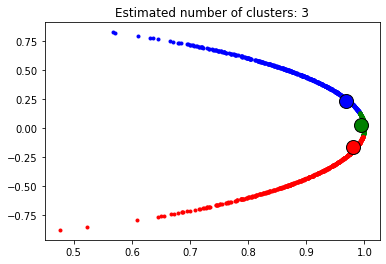

In [33]:
visualize_clustering_result_arr(tdidf_meanshift_clustering_lsa, X)

In [34]:
scores = []

score = list(calc_scores_arr(X, tdidf_meanshift_clustering_lsa))
score.insert(0, 'model with lsa embedding')
scores.append(score)


scores = pd.DataFrame(scores, columns=["model type","silhouette_score", "calinski_harabasz_score", "davies_bouldin_score"])
print(scores)

                 model type  silhouette_score  calinski_harabasz_score  \
0  model with lsa embedding          0.410777              2443.830097   

   davies_bouldin_score  
0              0.543272  


# Jessis plotting method

In [35]:
def plot(model, corpus, input_dense=False):
    random_state = 1
    #centroids = model.cluster_centers_

    tsne_init = 'pca'  # could also be 'random'
    tsne_perplexity = 20.0
    tsne_early_exaggeration = 4.0
    tsne_learning_rate = 10
    tsne = TSNE(n_components=2, random_state=random_state, init=tsne_init,
        perplexity=tsne_perplexity,
        early_exaggeration=tsne_early_exaggeration, learning_rate=tsne_learning_rate)
    
    if input_dense:
        transformed = tsne.fit_transform(corpus)
    else:
        transformed = tsne.fit_transform(corpus.todense())
    plt.scatter(transformed[:, 0], transformed[:, 1], c=model.labels_, marker='x')
    plt.show()

## Normal

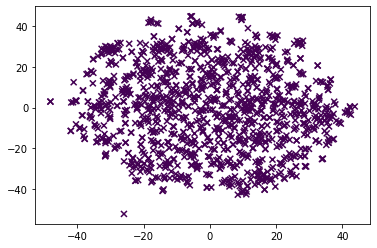

In [36]:
plot(tdidf_meanshift_clustering, tfidf_corpus)

## Spectral

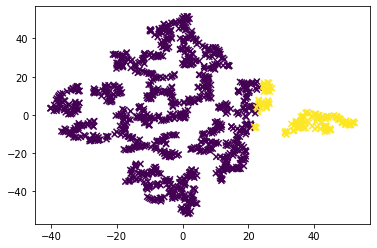

In [37]:
plot(tdidf_meanshift_clustering_spectral, tfidf_corpus_spec_embedding_array, True)

## LSA

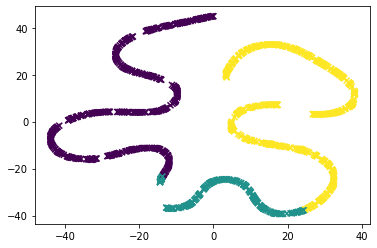

In [38]:
plot(tdidf_meanshift_clustering_lsa, X, True)